# Surprise-Library for Recommender Systems

In this notebook, we dive for the first time into a widely used code library optimized to develop and analyse recommender engines: the [Surprise](http://surpriselib.com/) library. 
- Surprise accepts user-own datasets, in addition to already built-in datasets
- Surprise enables implementing new prediction algorithms, in addition to many already-implemented algorithms it has
- Surprise offers extensive tools for evaluating and analysing the recommendation results

<br>

In this notebook:
- we fit some of the available algorithms on our small ratings dataset, and try to evaluate the performance.  
- we compare computed ratings with actual ratings for some case studies (example users)
- we have a special look at extreme users (the heavy raters)



We start with loading the necessary packages:

In [442]:
import sys
import pandas as pd
from pandas_profiling import ProfileReport

import numpy as np
import warnings
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline


In [443]:

df_ratings = pd.read_csv('../data/small/ratings.csv')
df_movies= pd.read_csv('../data/small/movies.csv')
df_tags = pd.read_csv('../data/small/tags.csv')
df_links = pd.read_csv('../data/small/links.csv')

In [444]:
df_movies.head()
df_movies.shape
df_ratings.head()
df_ratings.shape
df_tags.head()
df_tags.shape
df_links.head()
df_links.shape

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


(9742, 3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


(100836, 4)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


(3683, 4)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


(9742, 3)

Ratings dataframe include only movieIDs, which are not very transparent to the human eye. In order to gain insights about movies easily, we include movie titles from the movie dataframe in the ratings dataframe. 
By merging the two dataframes on movieId:

In [445]:
# Merging df_ratings and df_movies on movieId_id
df_movie_name = df_ratings.merge(df_movies[['movieId', 'title']], on='movieId')
df_movie_name.drop('timestamp', inplace=True, axis=1)
df_movie_name.sort_values(by='userId', inplace=True)
df_movie_name.head()



,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
12117,1,2389,2.0,Psycho (1998)
12126,1,2395,5.0,Rushmore (1998)
12182,1,2406,4.0,Romancing the Stone (1984)
776,1,70,3.0,From Dusk Till Dawn (1996)


Loading the surprise library:
1) a reader object is defined, with the ratings scale as an input
2) df_ratings is read with the defined reader object

In [446]:
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

Surprise has many algorithms to cluster the users (movie fans). We start here with exploring the avaliable algorithms

In [447]:
import random
from surprise import SVD
from surprise import KNNBasic
from surprise.model_selection import cross_validate

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

algo = KNNBasic()
#algo = SVD(verbose=True, n_epochs=10)
#cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9557  0.9468  0.9444  0.9507  0.9419  0.9479  0.0049  
MAE (testset)     0.7312  0.7282  0.7268  0.7255  0.7214  0.7266  0.0033  
Fit time          0.04    0.05    0.05    0.05    0.05    0.05    0.00    
Test time         0.57    0.59    0.59    0.60    0.57    0.59    0.01    


{'test_rmse': array([0.95572189, 0.94675474, 0.94443215, 0.95065679, 0.94186418]),
 'test_mae': array([0.73124068, 0.72819284, 0.72678669, 0.72547833, 0.72135809]),
 'fit_time': (0.0421900749206543,
  0.0476689338684082,
  0.04909491539001465,
  0.048963069915771484,
  0.04728102684020996),
 'test_time': (0.5697901248931885,
  0.5868391990661621,
  0.5949170589447021,
  0.6029760837554932,
  0.571709156036377)}

The basic version of K nearest neighbors algorithm has resulted in a mean RMSE value of 0.9479. This agrees well with the documented (benchmark) values on the Surprise library website.

<br>
Let's now used the fitted object (algo) to predict the rating of User number 10 to the movie with the ID 100: 

In [448]:
algo1.predict(uid=10, iid=100)

Prediction(uid=10, iid=100, r_ui=None, est=2.8562762928386247, details={'actual_k': 8, 'was_impossible': False})

We create here a small practical function to show all user information:

In [449]:
def who_is_this_user(uid):
    """returns user profile, i.e., all the films rated by this user"""
    user_profile = df_movie_name[df_movie_name['userId']==uid]
    return user_profile


# example output:
who_is_this_user(3)



,userId,movieId,rating,title
18092,3,31,0.5,Dangerous Minds (1995)
18662,3,3210,0.5,Fast Times at Ridgemont High (1982)
18168,3,720,0.5,Wallace & Gromit: The Best of Aardman Animatio...
18835,3,72378,0.5,2012 (2009)
18832,3,70946,5.0,Troll 2 (1990)
18827,3,7991,5.0,Death Race 2000 (1975)
18826,3,7899,4.5,Master of the Flying Guillotine (Du bi quan wa...
18825,3,6835,5.0,Alien Contamination (1980)
18816,3,6238,0.5,Green Card (1990)
18814,3,5919,5.0,Android (1982)


Comparing predicted ratings with actual ratings:
- Choose a user:

In [450]:

#choose user ID

user_id = 3

movies_rated_by_user = list(df_movie_name[df_movie_name['userId'] == user_id].sort_values(by='movieId').movieId.unique())

print('movie_id', '_ ', 'predicted','_ ', 'actual')

for movie in movies_rated_by_user:
    predicted = algo.predict(uid=user_id, iid=movie).est
    try:
        predicted = predicted.round(1)
    except:
        pass
    mask1 = df_movie_name['userId'] == user_id
    mask2 = df_movie_name['movieId'] == movie
    actual = df_movie_name[(mask1 & mask2)].rating
    #type(list(actual)[0])
    print(movie, '_ _ _ _', predicted,'_ _ _ _', list(actual)[0])


movie_id _  predicted _  actual
31 _ _ _ _ 2.5 _ _ _ _ 0.5
527 _ _ _ _ 2.2 _ _ _ _ 0.5
647 _ _ _ _ 3.8 _ _ _ _ 0.5
688 _ _ _ _ 1.5 _ _ _ _ 0.5
720 _ _ _ _ 3.9 _ _ _ _ 0.5
849 _ _ _ _ 3.4 _ _ _ _ 5.0
914 _ _ _ _ 4.3 _ _ _ _ 0.5
1093 _ _ _ _ 2.5 _ _ _ _ 0.5
1124 _ _ _ _ 2.1 _ _ _ _ 0.5
1263 _ _ _ _ 2.8 _ _ _ _ 0.5
1272 _ _ _ _ 2.4 _ _ _ _ 0.5
1275 _ _ _ _ 3.7 _ _ _ _ 3.5
1302 _ _ _ _ 2.5 _ _ _ _ 0.5
1371 _ _ _ _ 2.9 _ _ _ _ 3.0
1587 _ _ _ _ 3.5 _ _ _ _ 4.5
2018 _ _ _ _ 2.6 _ _ _ _ 0.5
2080 _ _ _ _ 3.1 _ _ _ _ 0.5
2090 _ _ _ _ 2.0 _ _ _ _ 0.5
2105 _ _ _ _ 3.1 _ _ _ _ 2.0
2288 _ _ _ _ 3.9 _ _ _ _ 4.0
2424 _ _ _ _ 2.2 _ _ _ _ 0.5
2851 _ _ _ _ 4.4 _ _ _ _ 5.0
3024 _ _ _ _ 3.7 _ _ _ _ 4.5
3210 _ _ _ _ 2.9 _ _ _ _ 0.5
3703 _ _ _ _ 4.4 _ _ _ _ 5.0
3949 _ _ _ _ 2.8 _ _ _ _ 0.5
4518 _ _ _ _ 4.6 _ _ _ _ 5.0
5048 _ _ _ _ 1.3 _ _ _ _ 0.5
5181 _ _ _ _ 4.6 _ _ _ _ 5.0
5746 _ _ _ _ 5 _ _ _ _ 5.0
5764 _ _ _ _ 4.5 _ _ _ _ 4.5
5919 _ _ _ _ 4.8 _ _ _ _ 5.0
6238 _ _ _ _ 1.7 _ _ _ _ 0.5
6835 _ _ _ _ 5 _ _ _ 

Hypothesis: Predicted values tend to be in the middle of the rating range? Does the model avoids extreme ratings?

Calculating user predictions for ALL movies
- Filter only the "5" ratings

In [451]:
# comparing predicted ratings with actual ratings

#choose user = x
user_id = 3

all_movies = list(df_movie_name.sort_values(by='movieId').movieId.unique())

print('movie_id', '_ ', 'predicted')
for movie in all_movies:
    predicted = algo.predict(uid=user_id, iid=movie).est
    try:
        predicted = predicted.round(1)
    except:
        pass
    #type(list(actual)[0])
    if predicted == 5 : print(movie, '_ _ _ _', predicted,'_ _ _ _')
    #print(movie, '_ _ _ _', predicted,'_ _ _ _') 

movie_id _  predicted
53 _ _ _ _ 5 _ _ _ _
85 _ _ _ _ 5 _ _ _ _
467 _ _ _ _ 5 _ _ _ _
495 _ _ _ _ 5 _ _ _ _
633 _ _ _ _ 5 _ _ _ _
685 _ _ _ _ 5 _ _ _ _
1140 _ _ _ _ 5 _ _ _ _
1151 _ _ _ _ 5 _ _ _ _
1310 _ _ _ _ 5 _ _ _ _
1349 _ _ _ _ 5 _ _ _ _
1699 _ _ _ _ 5 _ _ _ _
1759 _ _ _ _ 5 _ _ _ _
2007 _ _ _ _ 5 _ _ _ _
2068 _ _ _ _ 5 _ _ _ _
2075 _ _ _ _ 5 _ _ _ _
2196 _ _ _ _ 5 _ _ _ _
2239 _ _ _ _ 5.0 _ _ _ _
2295 _ _ _ _ 5 _ _ _ _
2512 _ _ _ _ 5 _ _ _ _
2624 _ _ _ _ 5 _ _ _ _
2824 _ _ _ _ 5 _ _ _ _
2972 _ _ _ _ 5 _ _ _ _
3046 _ _ _ _ 5 _ _ _ _
3073 _ _ _ _ 5 _ _ _ _
3086 _ _ _ _ 5 _ _ _ _
3096 _ _ _ _ 5 _ _ _ _
3241 _ _ _ _ 5 _ _ _ _
3303 _ _ _ _ 5 _ _ _ _
3473 _ _ _ _ 5 _ _ _ _
3496 _ _ _ _ 5 _ _ _ _
3531 _ _ _ _ 5 _ _ _ _
3637 _ _ _ _ 5 _ _ _ _
3678 _ _ _ _ 5 _ _ _ _
3687 _ _ _ _ 5 _ _ _ _
3787 _ _ _ _ 5 _ _ _ _
3792 _ _ _ _ 5 _ _ _ _
3951 _ _ _ _ 5 _ _ _ _
4116 _ _ _ _ 5 _ _ _ _
4135 _ _ _ _ 5 _ _ _ _
4142 _ _ _ _ 5 _ _ _ _
4180 _ _ _ _ 5 _ _ _ _
4273 _ _ _ _ 5 _ _ _ _
4294 _ _ _ _ 5 _ _

Hypothesis: False. The model can predict many 5.0 ratings. Distribution?

Plotting predicted ratings vs. actual ratings with different algorithms for a specific user

In [452]:
# we expand the who_is_this_user dataframe with extra column for the predicted ratings according to
# different algorithms

def who_is_this_user(uid):
    """returns user profile, i.e., all the films rated by this user"""
    user_profile = df_movie_name[df_movie_name['userId']==uid]
    return user_profile



In [453]:


algo_knn = KNNBasic()
algo_svd = SVD(verbose=True, n_epochs=10)
algos = {'KNN':algo_knn,'SVD':algo_svd}


def user_predictions_df(uid, algos=algos, df_movie_name=df_movie_name):
    df = who_is_this_user(uid)
    for algo in list(algos):
        cross_validate(algos[algo], data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
        pred_list = []
        for movie_id in df_movie_name[df_movie_name.userId == uid].movieId: 
            #print(type(i))
            prediction = algos[algo].predict(uid=uid, iid=movie_id).est
            prediction = float(prediction)
            prediction = round(prediction, 1)
            pred_list.append(prediction)
            #print(prediction)
        # create feature column in user_df
        df.insert(3, 'rating_' + algo, np.array(pred_list))
    return df


In [454]:
df_tobeplotted = user_predictions_df(1)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processi

With the goal to compare graphically the actual ratings of a specific user to the computed ratings according to different algorithms, we build the function plot_ratings:

In [455]:

def plot_ratings(user_id):
        df_tobeplotted = user_predictions_df(user_id)
        df_tobeplotted = df_tobeplotted.sort_values(by='rating', ascending=False).reset_index()
        plt =sns.lineplot(data=df_tobeplotted[[ 'rating_KNN', 'rating_SVD']], linewidth = 1)
        sns.set(rc={'figure.figsize':(20,8.27)})
        plt.set(title=f"Comparing Ratings for User {user_id}" , 
                xlabel=f"Individual Movies rated by user {user_id}",
                ylabel="Rating")
        sns.lineplot(data=df_tobeplotted[['rating']] , linewidth = 5)
        return plt
        

### Study case: User Nr. ?

Here we can go in details about a specific user and explore his actual ratings compared to the predicted ratings with the models implemented in the Surprise library:

- Let's study the behavior of User number 1:

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processi

<AxesSubplot:title={'center':'Comparing Ratings for User 1'}, xlabel='Individual Movies rated by user 1', ylabel='Rating'>

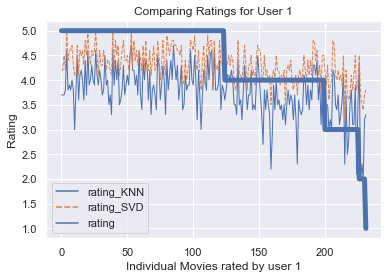

In [456]:
plot_ratings(1)

The graph shows interesting results:
- KNN ratings are generally lower than those of SVD
- Both algorithms under-estimate the higher ratings, yet they overestimate the lower ones
- In general, KNN shows more variation than SVD
- SVD comes closer to the actual ratings in the region of higher ratings. Yet it fails enormously at lower ratings. 

Yet we are able to relate some of these observations to the profile of this specific user (User 1):

- He/she is highly generous rater, as most of their ratings higher than three stars
- This impalanced rating behaviour would not lead to an optimally fitted algorithm for this user
- The few number of lower ratings could explain where the algorithms fail in this domain

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processi

<AxesSubplot:title={'center':'Comparing Ratings for User 2'}, xlabel='Individual Movies rated by user 2', ylabel='Rating'>

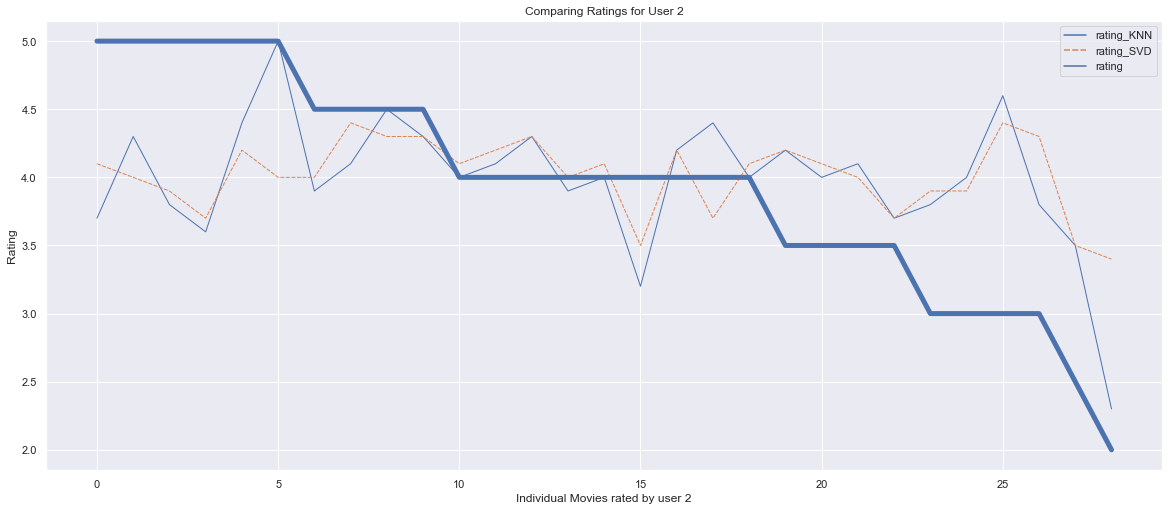

In [457]:
plot_ratings(2)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9453  0.9448  0.9386  0.9589  0.9480  0.9471  0.0067  
MAE (testset)     0.7257  0.7268  0.7192  0.7327  0.7271  0.7263  0.0043  
Fit time          0.06    0.05    0.05    0.05    0.05    0.05    0.00    
Test time         0.61    0.61    0.62    0.60    0.60    0.61    0.01    
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing 

<AxesSubplot:title={'center':'Comparing Ratings for User 3'}, xlabel='Individual Movies rated by user 3', ylabel='Rating'>

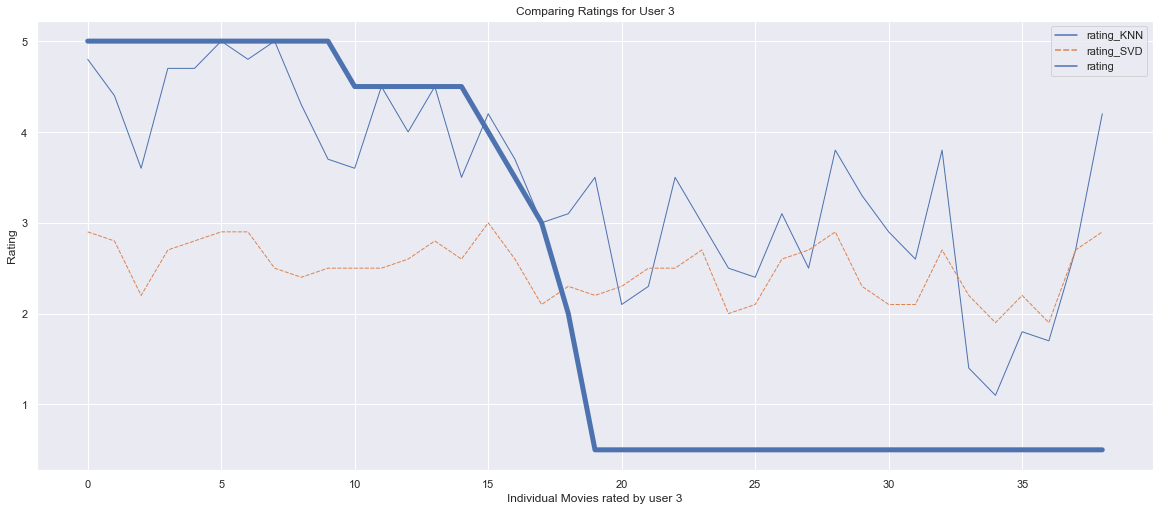

In [419]:
plot_ratings(3)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9535  0.9506  0.9428  0.9474  0.9445  0.9478  0.0039  
MAE (testset)     0.7306  0.7283  0.7223  0.7283  0.7209  0.7261  0.0038  
Fit time          0.07    0.06    0.05    0.05    0.05    0.05    0.01    
Test time         0.60    0.62    0.60    0.60    0.60    0.61    0.01    
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing 

<AxesSubplot:title={'center':'Comparing Ratings for User 100'}, xlabel='Individual Movies rated by user 100', ylabel='Rating'>

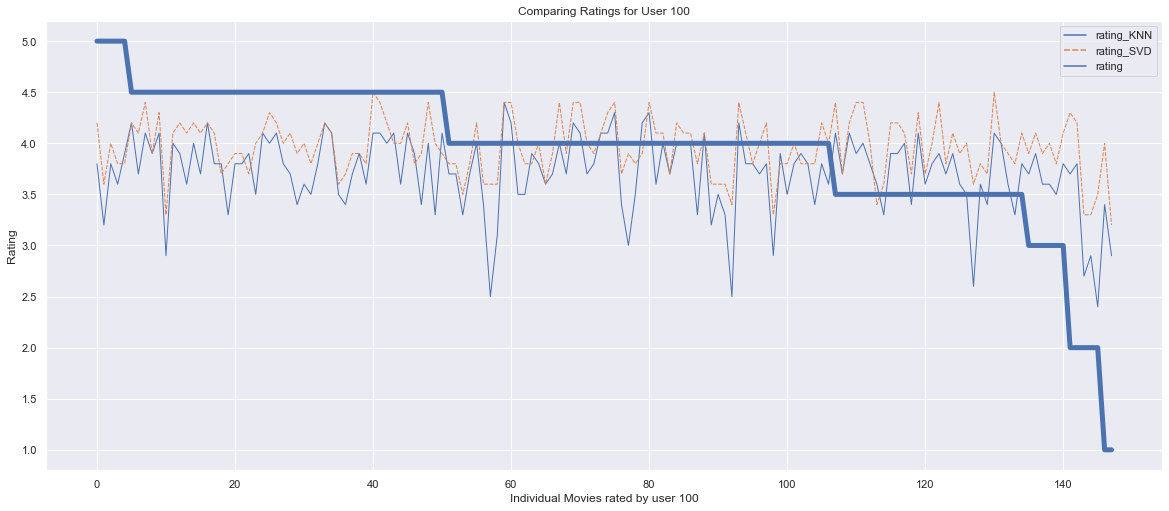

In [420]:
plot_ratings(100)

### Let's look for the most-frequent reviewer in our dataset:

In [310]:
df_movie_name.groupby('userId').count().sort_values(by='movieId', ascending=False).head()

,movieId,rating,title
userId,,,
414,2698,2698,2698
599,2478,2478,2478
474,2108,2108,2108
448,1864,1864,1864
274,1346,1346,1346


### It's user 414! Let's plot his ratings

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processi

<AxesSubplot:title={'center':'Comparing Ratings for User 414'}, xlabel='Individual Movies rated by user 414', ylabel='Rating'>

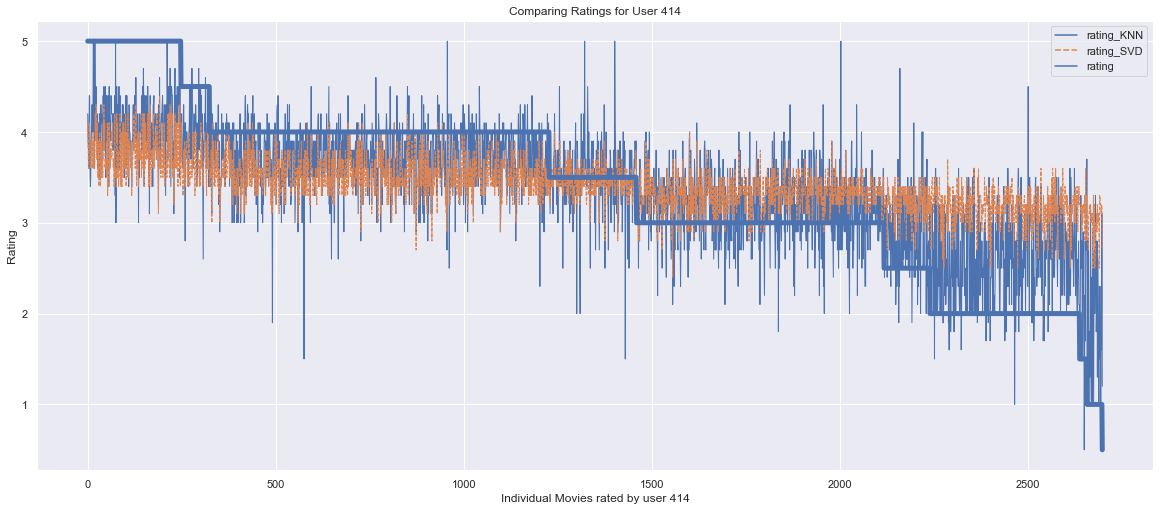

In [458]:
plot_ratings(414)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processi

<AxesSubplot:title={'center':'Comparing Ratings for User 599'}, xlabel='Individual Movies rated by user 599', ylabel='Rating'>

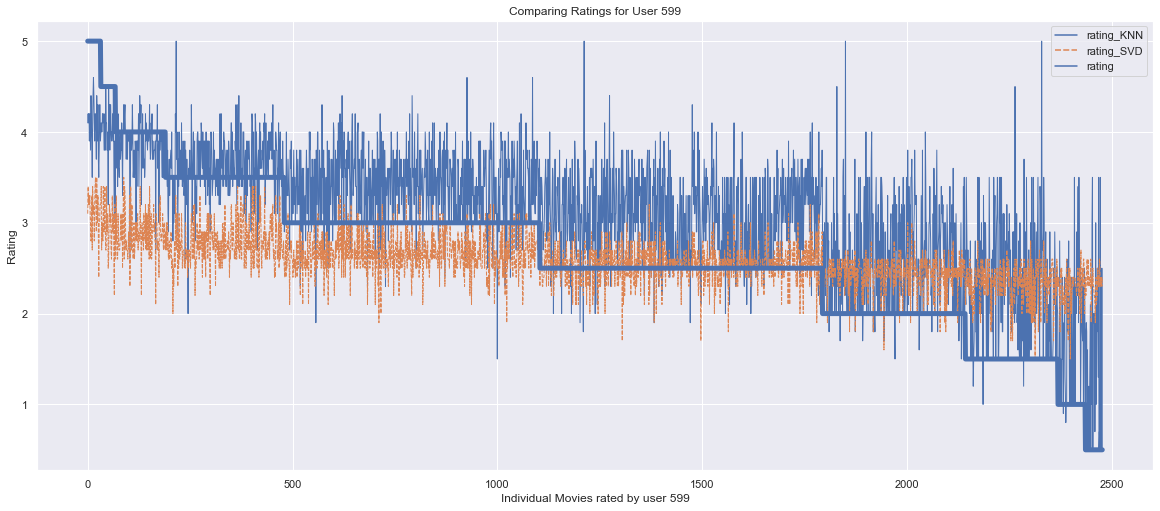

In [459]:
plot_ratings(599)